In [1]:
import pandas
rnaseq = pandas.read_csv('training/rnaseq.csv')
aucs = pandas.read_csv('training/aucs.csv')

In [2]:
%pip install synapseclient
import getpass
import pandas
import synapseclient
import synapseutils

Note: you may need to restart the kernel to use updated packages.


In [3]:
from util import TransposeRnaSeqTable

specimens = TransposeRnaSeqTable(rnaseq)
selected_genes = specimens.var().nlargest(20000).index.tolist()

In [4]:
print("%.1f%% of (inhibitor, specimen) pairs have AUCs." % (
    100 * aucs.shape[0] / float(len(aucs.inhibitor.unique()) * len(aucs.lab_id.unique()))))

77.9% of (inhibitor, specimen) pairs have AUCs.


In [5]:
from matplotlib import pyplot
import numpy
import seaborn
from sklearn.linear_model import RidgeCV

# Normalize each specimen.
X = specimens
X = X.div(numpy.linalg.norm(X, axis=1), axis=0)
X = X[selected_genes]


# Compute z-score.
gene_mean = X.mean(axis=0)
gene_std = X.std(axis=0)
X = (X - gene_mean) / gene_std

# For each inhibitor, train a regressor.
alphas = numpy.logspace(-1, 5, num=40)
regressors = {}
for inhibitor in aucs.inhibitor.unique():
    auc_subset = aucs[aucs.inhibitor == inhibitor]
    regr = RidgeCV(alphas=alphas, store_cv_values=True)
    regr = regr.fit(X.loc[auc_subset.lab_id], auc_subset.auc)
    regressors[inhibitor] = regr

In [6]:
# len(regressors)

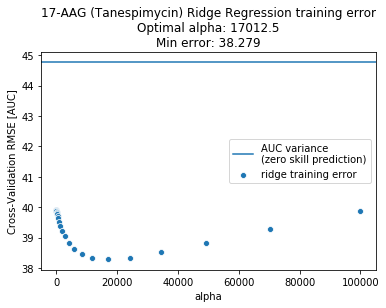

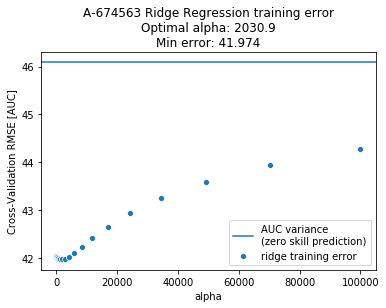

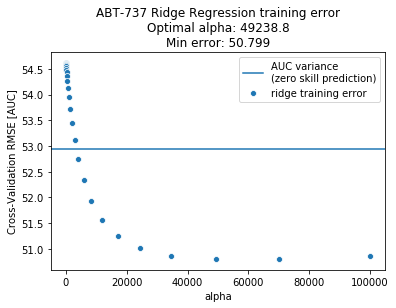

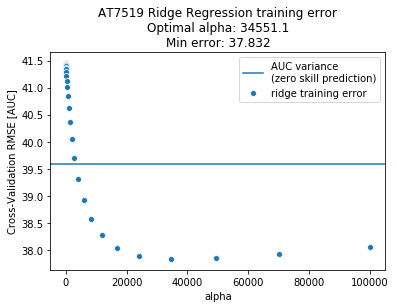

In [7]:

# Plot the highest error and lowest error.
def plotRegressor(inhibitor, regr):
    pyplot.figure()
    errors = numpy.sqrt(regr.cv_values_.mean(axis=0))
    seaborn.scatterplot(x=alphas, y=errors, label='ridge training error')
    pyplot.axhline(
        y=aucs[aucs.inhibitor == inhibitor].auc.std(),
        label='AUC variance\n(zero skill prediction)')

    # Annotate.
    pyplot.xlabel('alpha')
    pyplot.ylabel('Cross-Validation RMSE [AUC]')
    pyplot.title('%s Ridge Regression training error\nOptimal alpha: %0.1f\nMin error: %.3f' % (
        inhibitor, regr.alpha_, min(errors)))
    pyplot.legend()

for inhibitor in aucs.inhibitor.unique()[0:4]:
    plotRegressor(inhibitor, regressors[inhibitor])

In [8]:
#regr.coef_

In [9]:

pkl_1_dict = {
    'gene': selected_genes,
    'gene_mean': gene_mean,
    'gene_std': gene_std,
}
for inhibitor, regr in regressors.items():
    pkl_1_dict[inhibitor] = regr.coef_
pkl_1_out = pandas.DataFrame(pkl_1_dict)

pkl_2_out = pandas.DataFrame({
    'inhibitor': [inhibitor for inhibitor in regressors.keys()],
    'intercept': [regr.intercept_ for regr in regressors.values()],
})
pkl_1_out.to_csv('model/pkl_1.csv', index=False)
pkl_2_out.to_csv('model/pkl_2.csv', index=False)

In [10]:
# Join groundtruth onto predictions, because predictions is a
# superset of groundtruth.
indices = ['lab_id', 'inhibitor']
groundtruth = pandas.read_csv('training/aucs.csv').set_index(indices)
predictions = pandas.read_csv('output/predictions.csv').set_index(indices)
predictions_and_groundtruth = groundtruth.join(
    predictions, lsuffix='_groundtruth', rsuffix='_prediction')